# Clustering for gevtevsimbad

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from sklearn.neighbors import DistanceMetric
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import cluster
from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
#path_to_gamma_bins shoud contain an absolute path to your gamma-bins directory
path_to_gamma_bins = os.path.dirname(os.getcwd()) + "/"

In [3]:
#name columns included in the final display
other_names = ['s_MAIN_ID', 's_class', 'gev_1FGL_Name', 'gev_CLASS1', 'tev_fermi_names', 'tev_classes', 'marked']
#from gamma bins directory
path_to_catalog = "markeddata/normalized_spectra.txt"

In [4]:
spectra = pd.read_csv(path_to_gamma_bins +path_to_catalog)
spectra.head()

,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,tev_3TeV,tev_10TeV,tev_30TeV,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,0.013537,0.343081,0.020826,0.143005,0.330419,0.0,0.0,0.000000,0.000000,0.0,...,0.012135,0.004136,0.000407,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,0.013335,0.013325,0.000805,0.014451,0.004808,0.0,0.0,0.004396,0.019638,0.0,...,0.007655,0.004429,0.002622,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,0.001682,0.042624,0.002587,0.017767,0.041051,0.0,0.0,0.000000,0.000000,0.0,...,0.001508,0.000514,0.000051,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.0,0.000000,0.000000,0.0,...,0.000969,0.000719,0.001111,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,0.012809,0.324638,0.019706,0.135318,0.312657,0.0,0.0,0.000000,0.000000,0.0,...,0.011482,0.003914,0.000385,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


In [5]:
spectrum_columns = spectra.columns[:-len(other_names)]

In [6]:
def get_distance_metric(metric_function):
    if type(metric_function) == str:
        dist = DistanceMetric.get_metric(metric_function)
    else:
        dist = DistanceMetric.get_metric("pyfunc", func=metric_function)
    return dist

In [7]:
def build_images():
    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])

    plt.subplots(figsize=(18, 6))
    plt.subplot(131)
    plt.title("PCA")
    pca = PCA(n_components=2, random_state=42)
    spectra_2D = pca.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(132)
    plt.title("TSNE, Euclidean distance")
    tsne = TSNE(n_components=2, random_state=42, learning_rate=500, n_iter=1500)
    spectra_2D = tsne.fit_transform(spectra[spectrum_columns])
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.subplot(133)
    plt.title("TSNE, Chosen distance")
    tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=300)
    spectra_2D = tsne.fit_transform(spectra_distances)
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)
    plt.show()
    
    
    # visualization - tsne with chosen distance
    print('Clustering')
    tsne = TSNE(n_components=2, random_state=42, metric="precomputed", learning_rate=300)
    spectra_2D = tsne.fit_transform(spectra_distances)
    plt.subplots(figsize=(18, 12))
    plt.subplot(3, 3, 1)

    colors = ['red','black']
    c = spectra['marked'].apply(lambda x: colors[x])
    plt.title("true labels")
    plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

    for n in range(2, 10):
        kmeans = cluster.KMeans(n_clusters=n, random_state=42)
        cluster_labels = kmeans.fit_predict(spectra_distances)

        plt.subplot(3, 3, n)
        c = [colors[l] for l in cluster_labels]
        plt.title("cluster labels ({} clusters)".format(n))
        plt.scatter(spectra_2D[:, 0], spectra_2D[:, 1], c=c, alpha=0.5)

    plt.show()
    
def print_clusters_structure(n):
    kmeans = cluster.KMeans(n_clusters=n, random_state=42)
    cluster_labels = kmeans.fit_predict(spectra_distances)
    centers = []

    spectra['KMeans_clusters_' + str(n)] = cluster_labels
    for i in range(n):
        print("{} cluster".format(i))
        display(spectra[spectra['KMeans_clusters_' + str(n)] == i][other_names])
        centers.append(spectra.loc[spectra['KMeans_clusters_' + str(n)] == i, spectrum_columns].mean(axis=0).values)
    centers = pd.DataFrame(np.column_stack(centers).T, columns=spectrum_columns)
    del spectra['KMeans_clusters_' + str(n)]

    # centroids
    print("centroids:")
    display(centers)
    # plt.figure(figsize=(20, 10))
    # sns.heatmap(centers, vmin=0, vmax=1)
    # plt.show()

* ### earth mover's distance

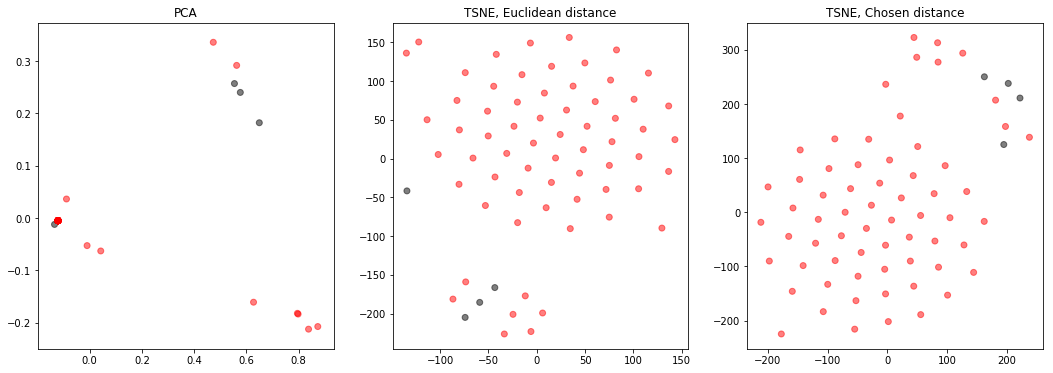

Clustering


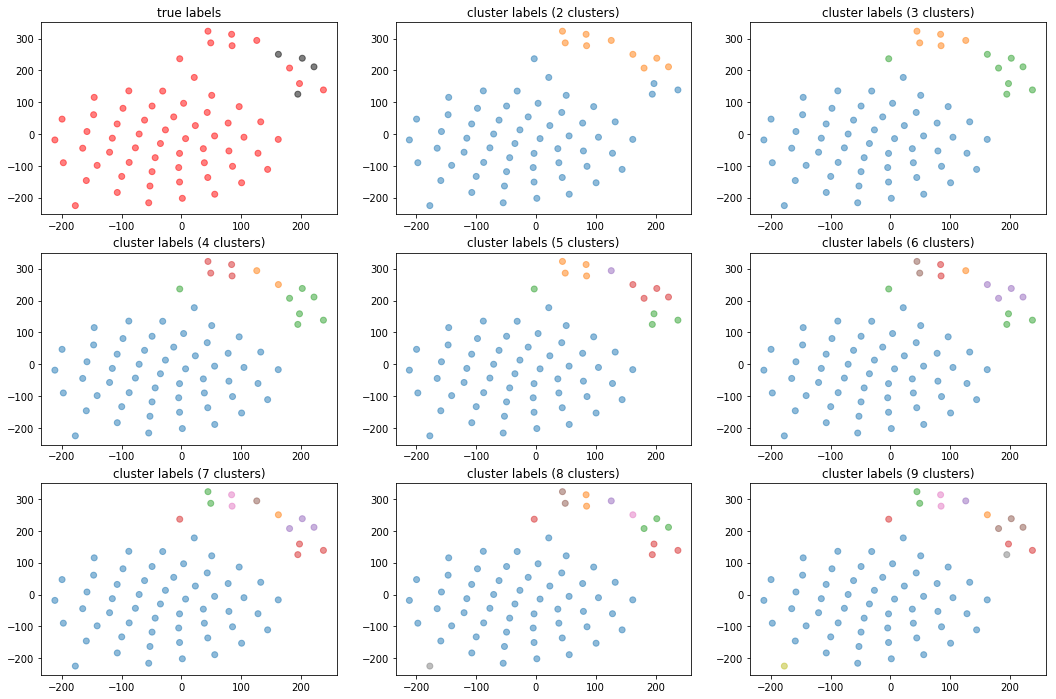

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.116499,0.289255,0.241801,0.120674,0.230597,0.0,5.612093e-15,2.234217e-14,2.244630e-08,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.006828,0.044097,0.001162,0.024807,0.030465,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.002988,0.004084,0.002664,0.001470,0.000885
2,0.011548,0.226707,0.087762,0.095433,0.250905,0.0,0.000000e+00,1.099091e-03,4.909455e-03,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.013058,0.012331,0.008216,0.003650,0.001913
3,0.000752,0.011981,0.008885,0.007465,0.010853,0.0,1.394698e-04,1.287994e-04,9.119498e-04,0.001722,...,0.0,0.000069,0.000515,0.001706,0.0,0.001755,0.001371,0.000982,0.000508,0.000166
4,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.005744,0.000322,0.000969,0.000719,0.001111


In [8]:
# earth mover's distance
metric_function = st.wasserstein_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
# spectra_distances = get_distance_metric(metric_function).pairwise(spectra[spectrum_columns])
#pd.DataFrame(spectra_distances).to_csv(path_to_gamma_bins +"markeddata/gevtev_spectra_EM_distances.txt", index=False)
build_images()
print_clusters_structure(5)

* ### euclidean distance

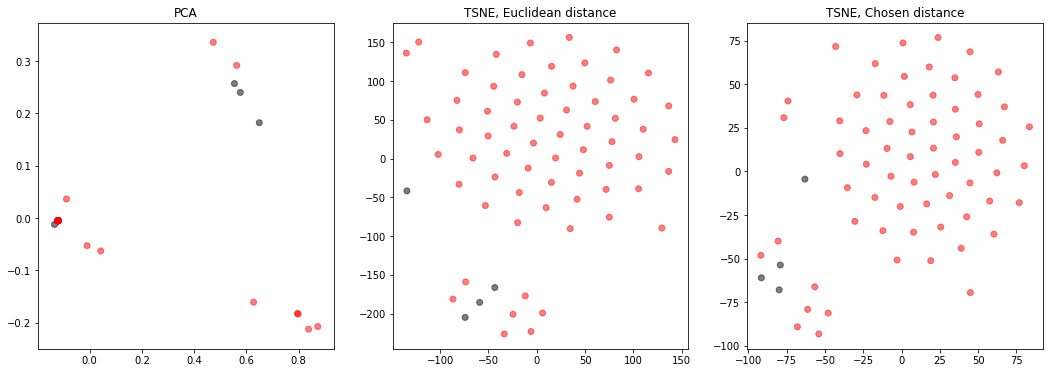

Clustering


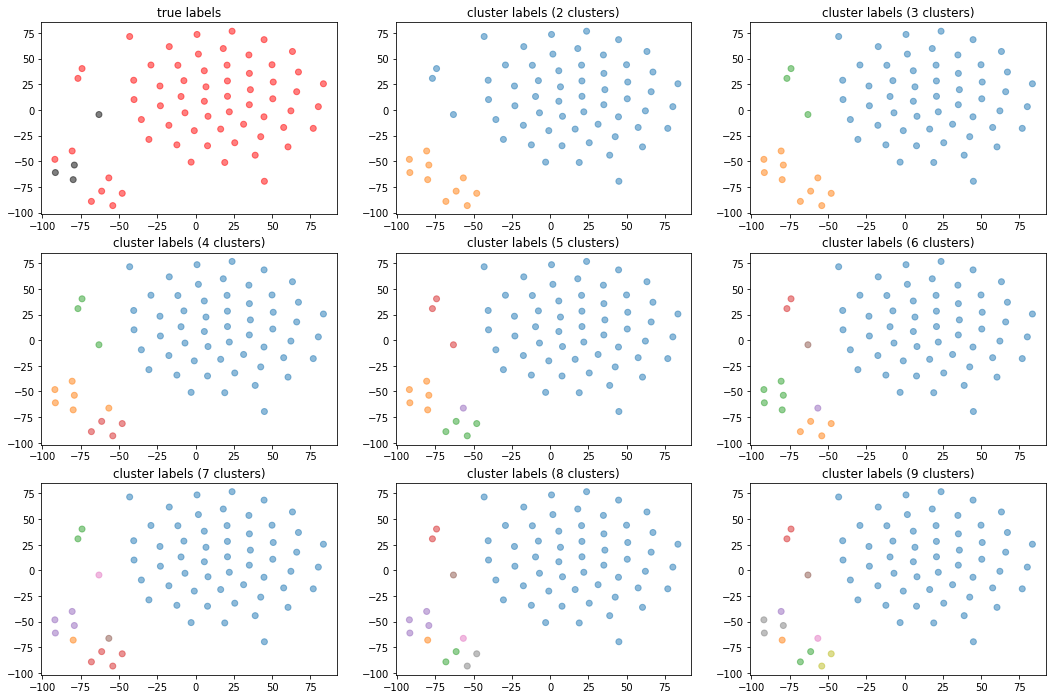

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.116499,0.289255,0.241801,0.120674,0.230597,0.0,5.612093e-15,2.234217e-14,2.244630e-08,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.006828,0.044097,0.001162,0.024807,0.030465,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.002988,0.004084,0.002664,0.001470,0.000885
2,0.003268,0.012250,0.007269,0.008862,0.009644,0.0,1.115758e-04,9.823123e-04,4.657124e-03,0.001378,...,0.0,0.000056,0.000412,0.001365,0.0,0.002559,0.003551,0.002316,0.001292,0.000657
3,0.013173,0.333859,0.020266,0.139161,0.321538,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.021575,0.017505,0.011808,0.004025,0.000396
4,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.005744,0.000322,0.000969,0.000719,0.001111
5,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.003307,0.002040,0.001594,0.002120,0.004238


In [9]:
# euclidean distance
from scipy.spatial.distance import euclidean
metric_function = "euclidean"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(6)

* ### cosine distance

$$ d(u, v) = 1 -  \frac{uv}{||u||_{2}||v||_{2}}$$

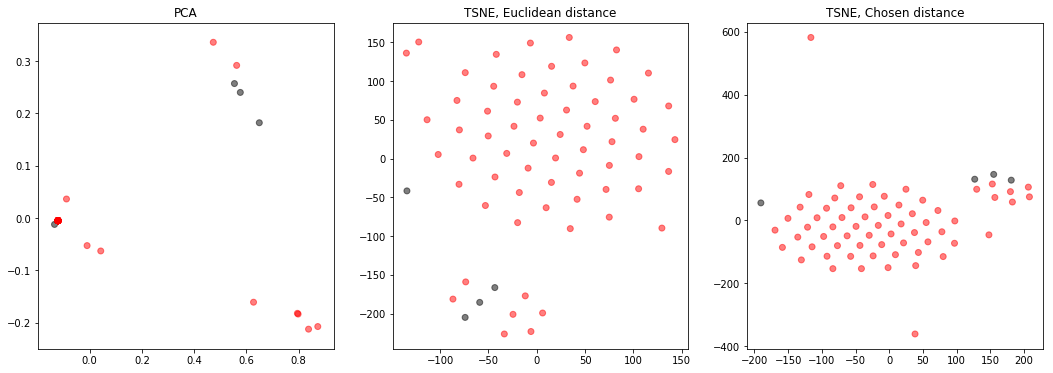

Clustering


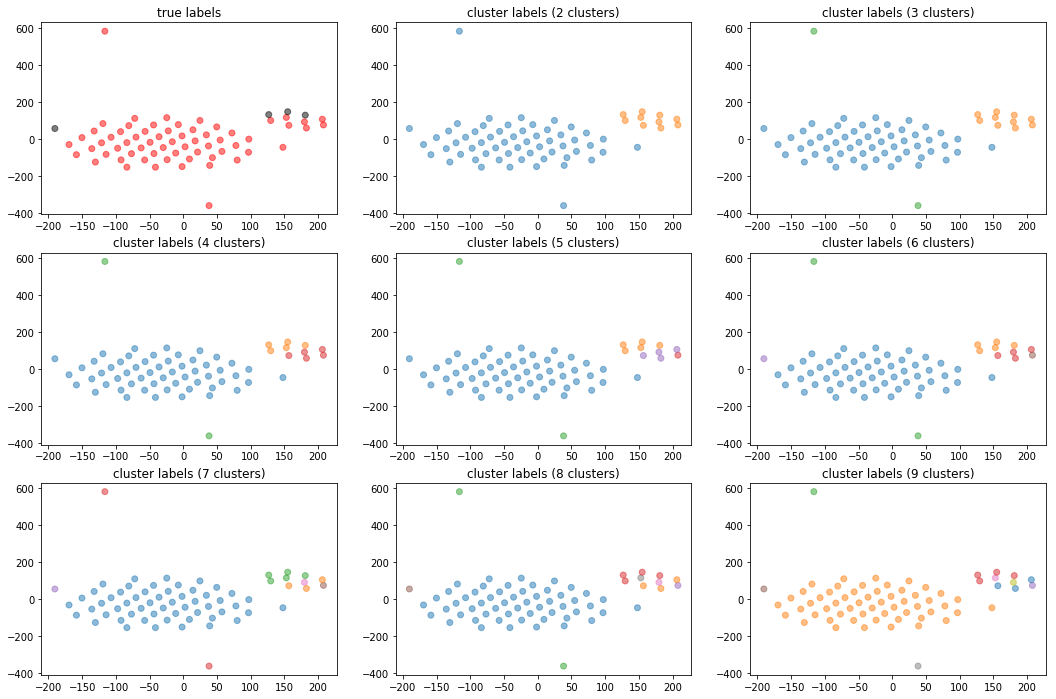

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.116499,0.289255,0.241801,0.120674,0.230597,0.0,5.612093e-15,2.234217e-14,2.244630e-08,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.003268,0.012250,0.007269,0.008862,0.009644,0.0,1.115758e-04,9.823123e-04,4.657124e-03,0.001378,...,0.0,0.000056,0.000412,0.001365,0.0,0.002559,0.003551,0.002316,0.001292,0.000657
2,0.013173,0.333859,0.020266,0.139161,0.321538,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.021575,0.017505,0.011808,0.004025,0.000396
3,0.006828,0.044097,0.001162,0.024807,0.030465,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.002988,0.004084,0.002664,0.001470,0.000885
4,0.006512,0.225784,0.309710,0.088960,0.355733,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.003307,0.002040,0.001594,0.002120,0.004238
5,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.005744,0.000322,0.000969,0.000719,0.001111


In [10]:
# cosine distance
# from scipy.spatial.distance import cosine
metric_function = "cosine"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(6)

* ### energy distance

The energy distance between two distributions $u$ and $v$ , whose respective CDFs are $U$ and $V$, equals to: 
$$D(u, v) = (2\mathbb{E}|X-Y| - {E}|X-X'| - {E}|Y-Y'|)^{\frac{1}{2}}$$
where $X$ and $Y$ (resp. $X'$  and $Y'$ ) are independent random variables whose probability distribution is  (resp. ).

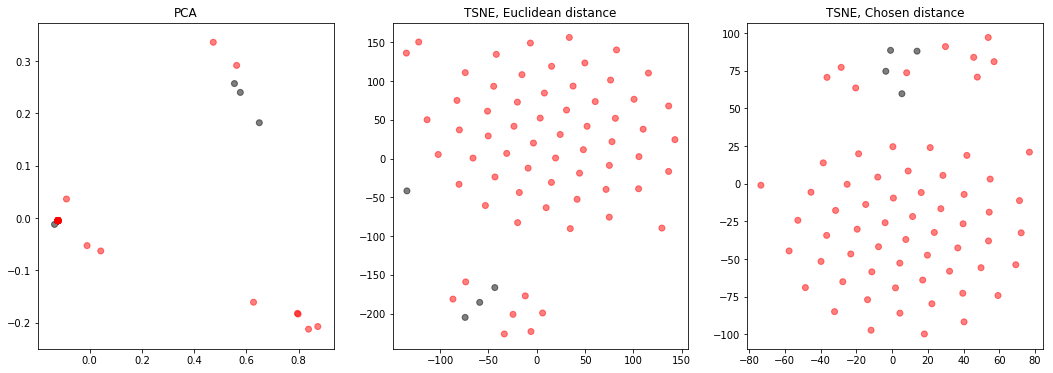

Clustering


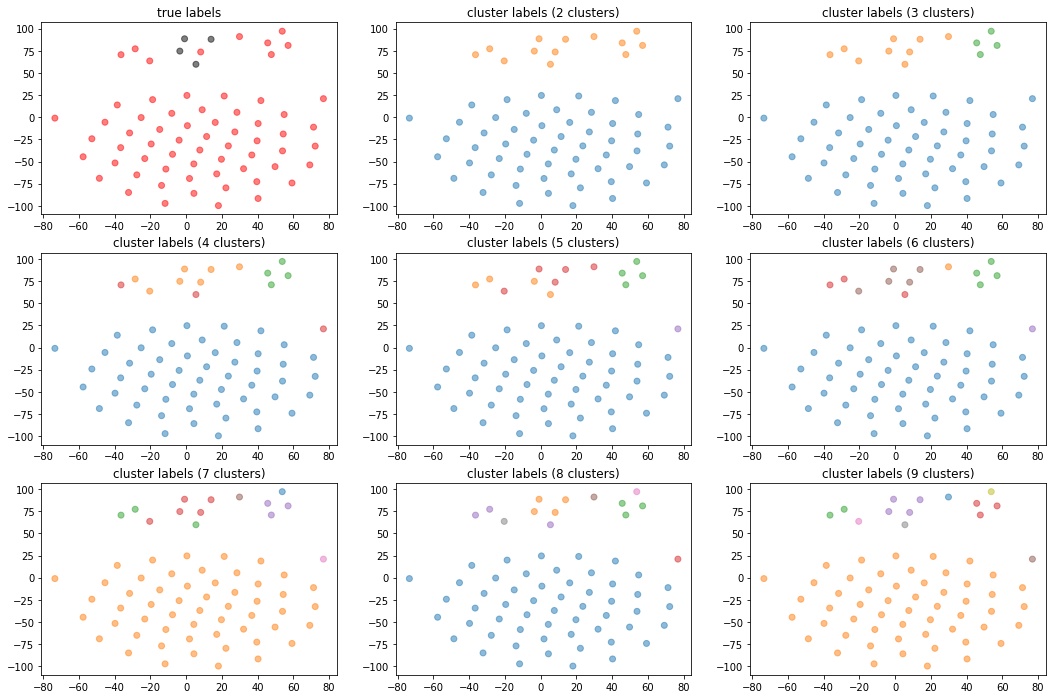

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
40,b'SN 2004am',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


5 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.116636,0.289595,0.242085,0.120816,0.230868,0.0,5.716021e-15,2.275591e-14,4.336056e-14,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.005744,0.000322,0.000969,0.000719,0.001111
2,0.006828,0.044097,0.001162,0.024807,0.030465,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.002988,0.004084,0.002664,0.001470,0.000885
3,0.010953,0.297834,0.116747,0.122427,0.332937,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.015486,0.012350,0.008404,0.003390,0.001677
4,0.109106,0.270901,0.226457,0.113017,0.215964,0.0,0.000000e+00,0.000000e+00,1.234544e-06,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.003268,0.012250,0.007269,0.008862,0.009644,0.0,1.115758e-04,9.823123e-04,4.657124e-03,0.001378,...,0.0,0.000056,0.000412,0.001365,0.0,0.002559,0.003551,0.002316,0.001292,0.000657


In [11]:
# energy distance
metric_function = st.energy_distance
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(6)

- ### mahalanobis
$$d(u, v) = \sqrt{(u-v)V^{-1}(u+v)^{T}}$$,
V - The inverse of the covariance matrix.

In [12]:
import scipy as sp
from scipy.spatial.distance import mahalanobis
spectra_spectra = spectra[spectra['marked'] != -1]
spectra_spectra = spectra_spectra.drop_duplicates()
spectra_spectra = spectra[spectrum_columns]
spectra_no_zeros = spectra.loc[(spectra_spectra!= 0).any(axis=1), :]
spectra_no_zeros2 = spectra_no_zeros.loc[:, (spectra_no_zeros != 0).any(axis=0)]
new_columns = [i for i in spectra_no_zeros2 if i in spectrum_columns]
covmx = spectra_no_zeros2[new_columns].cov()
invcovmx = sp.linalg.inv(covmx)

In [13]:
#func = lambda x, y : mahalanobis(x, y, invcovmx)

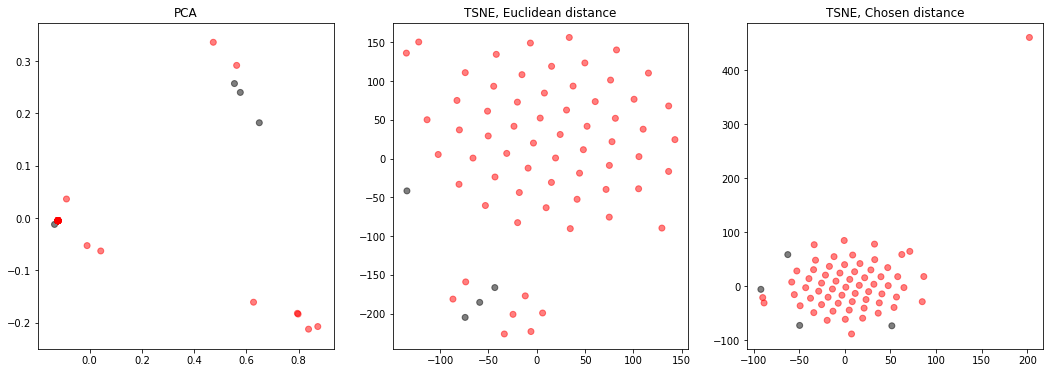

Clustering


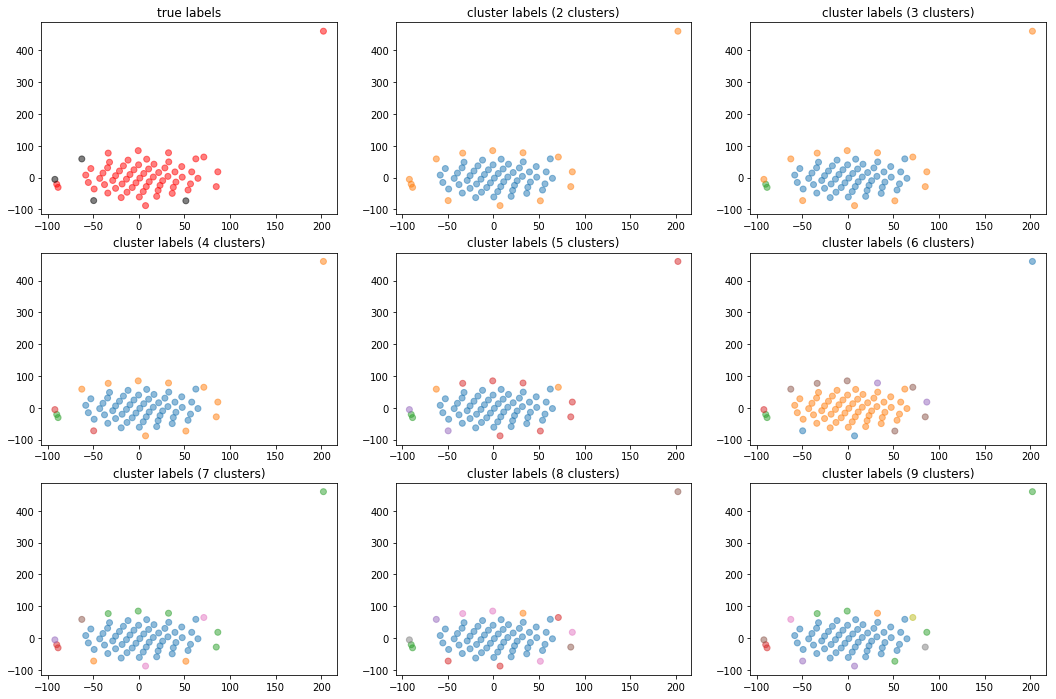

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.116636,0.289595,0.242085,0.120816,0.230868,0.0,5.716021e-15,2.275591e-14,4.336056e-14,0.000000,...,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.014073,0.109370,0.044210,0.049617,0.104778,0.0,3.984851e-05,3.508258e-04,1.663347e-03,0.000492,...,0.0,0.00002,0.000147,0.000487,0.0,0.005496,0.005105,0.003458,0.001659,0.000926


In [14]:
metric_function = "mahalanobis"
spectra_distances = pairwise_distances(spectra_no_zeros2[new_columns], metric=metric_function)
build_images()
print_clusters_structure(2)

- ### canberra
$$d(u, v) = \sum_{i} \frac{|u_i - v_i|}{|u_i| + |v_i|}$$

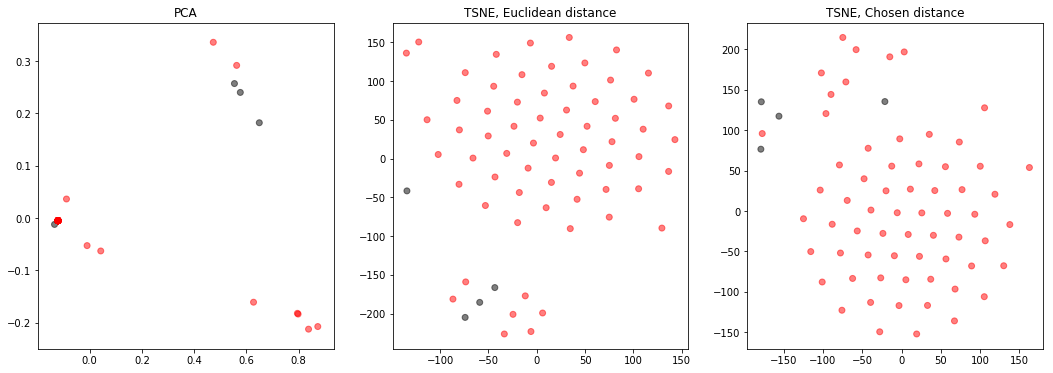

Clustering


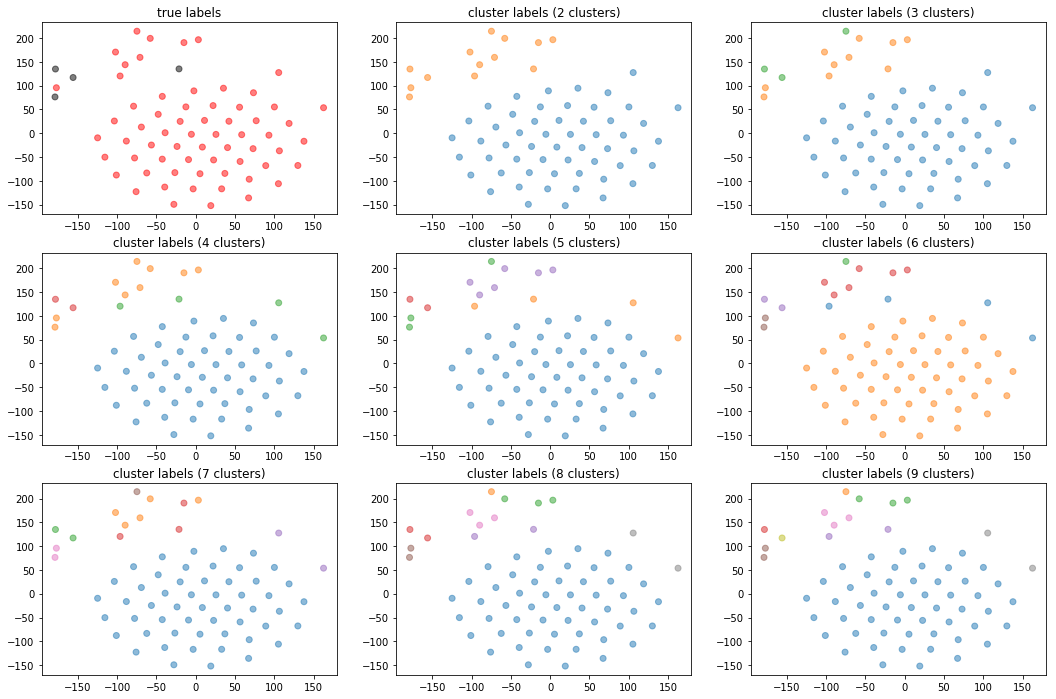

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1
40,b'SN 2004am',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
54,b'CXOM82 J095538.3+694030',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.116636,0.289595,0.242085,0.120816,0.230868,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.059375,0.211427,0.194706,0.088843,0.210079,0.0,7.716628e-14,3.072048e-13,3.086366e-07,0.000000,...,0.0,0.000000,0.00000,0.000000,0.0,0.000827,0.000510,0.000398,0.000530,0.001060
2,0.005209,0.016791,0.004077,0.013474,0.010113,0.0,4.956442e-05,1.566532e-03,7.189764e-03,0.000785,...,0.0,0.000000,0.00000,0.000000,0.0,0.001925,0.004091,0.002552,0.001476,0.000874
3,0.000357,0.005438,0.012057,0.001944,0.008939,0.0,2.045930e-04,1.059829e-04,8.581647e-04,0.002267,...,0.0,0.000139,0.00103,0.003411,0.0,0.003510,0.002742,0.001964,0.001016,0.000333
4,0.009969,0.152304,0.007642,0.069295,0.134870,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.00000,0.000000,0.0,0.010141,0.008612,0.005873,0.002441,0.000907


In [15]:
metric_function = "canberra"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(5)

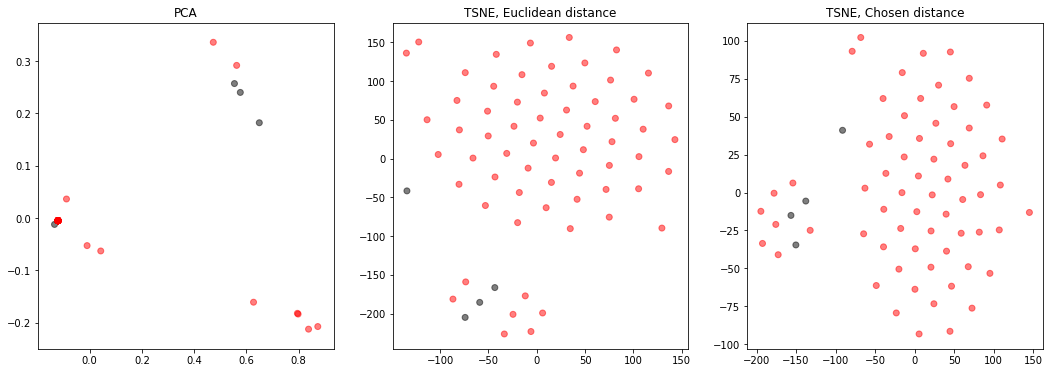

Clustering


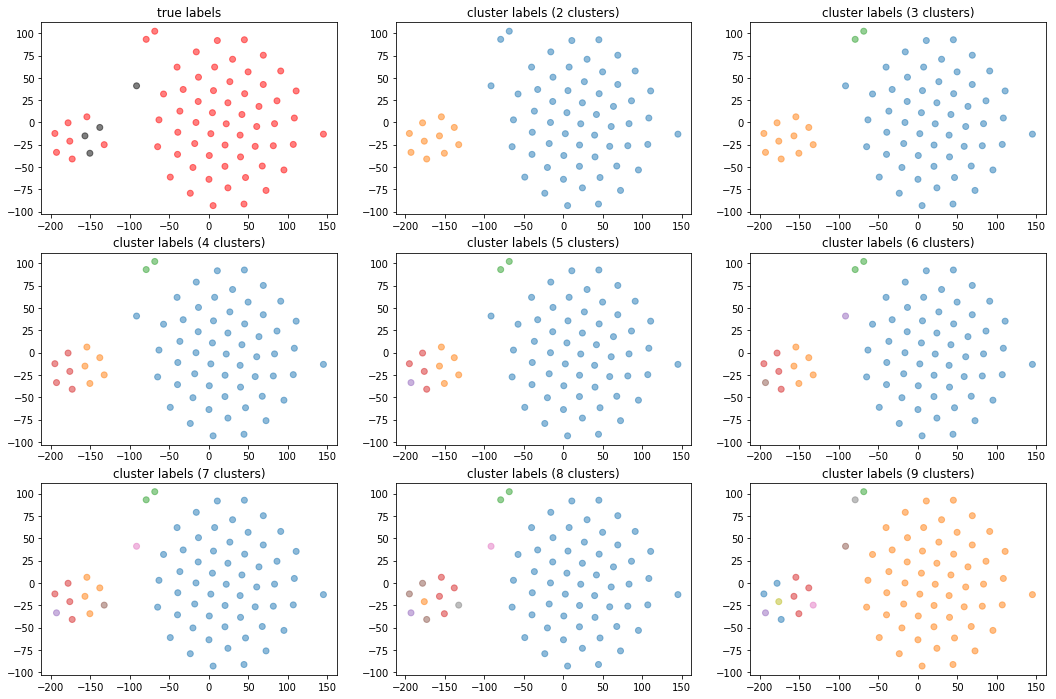

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.114535,0.288122,0.243013,0.120108,0.232832,0.0,5.511877e-15,2.194320e-14,2.204547e-08,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000059,0.000036,0.000028,0.000038,0.000076
1,0.003268,0.012250,0.007269,0.008862,0.009644,0.0,1.115758e-04,9.823123e-04,4.657124e-03,0.001378,...,0.0,0.000056,0.000412,0.001365,0.0,0.002559,0.003551,0.002316,0.001292,0.000657
2,0.013173,0.333859,0.020266,0.139161,0.321538,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.021575,0.017505,0.011808,0.004025,0.000396
3,0.006828,0.044097,0.001162,0.024807,0.030465,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.002988,0.004084,0.002664,0.001470,0.000885
4,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.005744,0.000322,0.000969,0.000719,0.001111


In [16]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(5)

- ### cityblock
$$ d(u, v) = \sum_{i} |u_i - v_i|$$

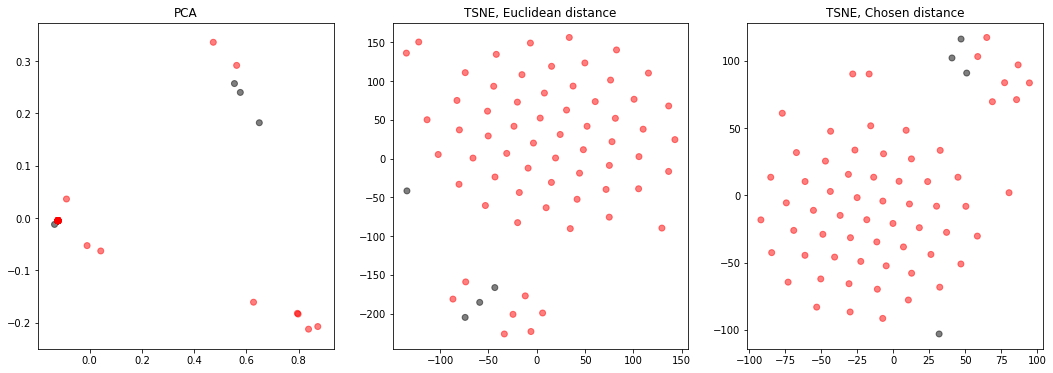

Clustering


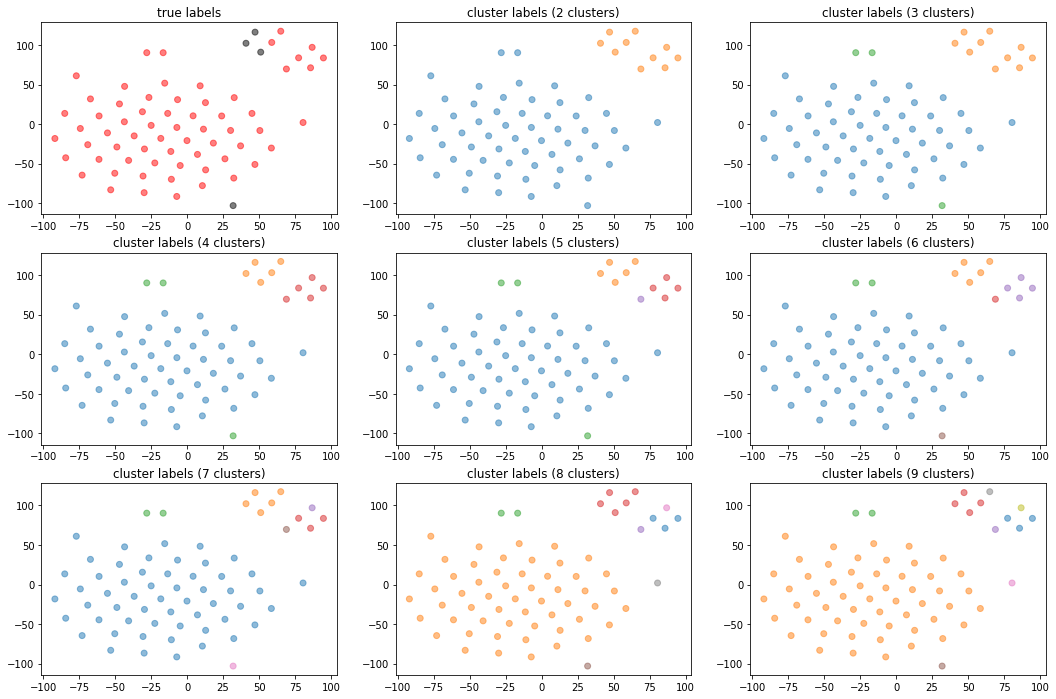

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.116499,0.289255,0.241801,0.120674,0.230597,0.0,5.612093e-15,2.234217e-14,2.244630e-08,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.003268,0.012250,0.007269,0.008862,0.009644,0.0,1.115758e-04,9.823123e-04,4.657124e-03,0.001378,...,0.0,0.000056,0.000412,0.001365,0.0,0.002559,0.003551,0.002316,0.001292,0.000657
2,0.010953,0.297834,0.116747,0.122427,0.332937,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.015486,0.012350,0.008404,0.003390,0.001677
3,0.006828,0.044097,0.001162,0.024807,0.030465,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.002988,0.004084,0.002664,0.001470,0.000885
4,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.005744,0.000322,0.000969,0.000719,0.001111


In [17]:
metric_function = "cityblock"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(5)

- ### braycurtis $$d(u, v) = \frac{\sum_{i} |u_i - v_i|}{\sum_{i}|u_i + v_i|}$$

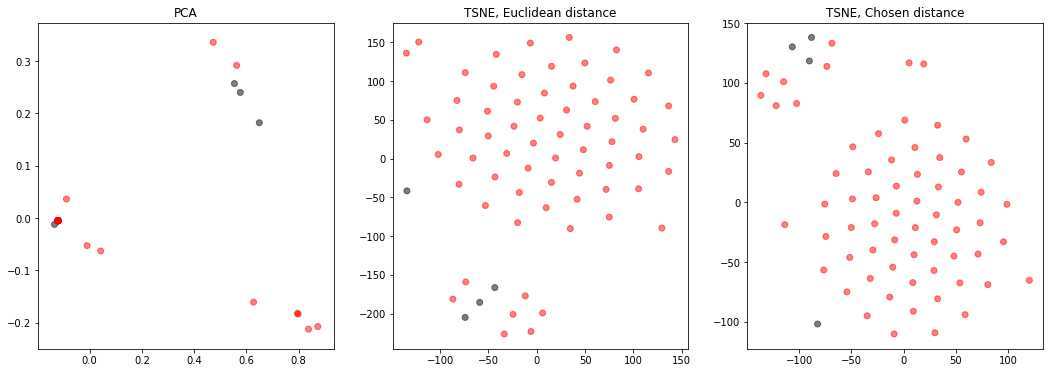

Clustering


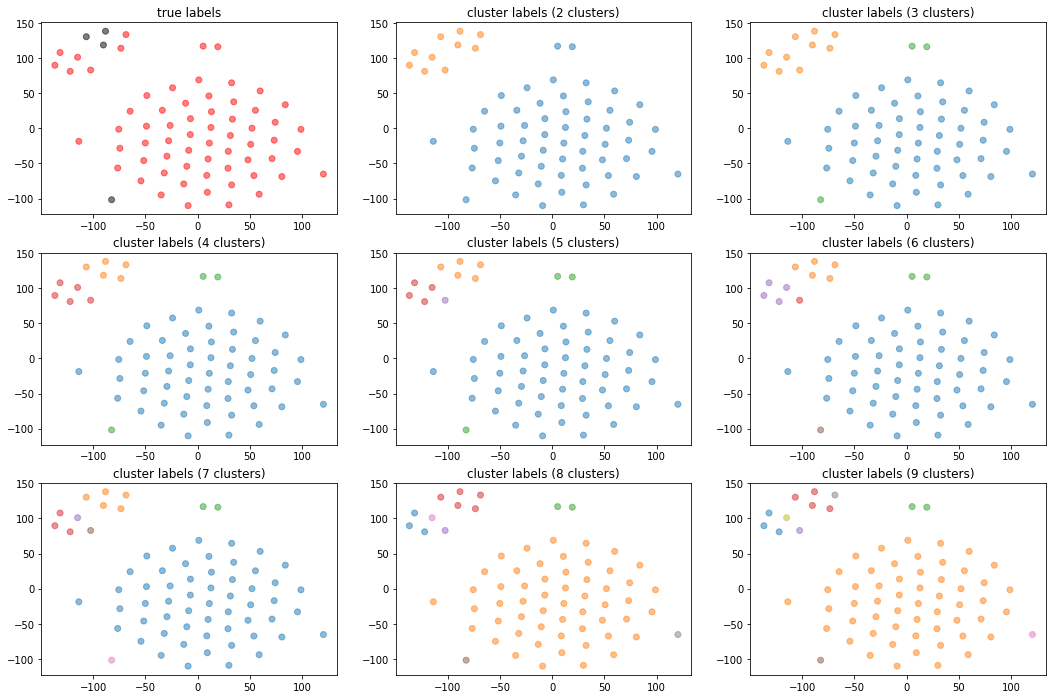

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0
38,b'2FGL J1019.0-5856',B0Ve,b'1FGL J1018.6-5856 ',b'HMB ',b'1FGL J1018.6-5856',b'bin',1


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.116499,0.289255,0.241801,0.120674,0.230597,0.0,5.612093e-15,2.234217e-14,2.244630e-08,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.003268,0.012250,0.007269,0.008862,0.009644,0.0,1.115758e-04,9.823123e-04,4.657124e-03,0.001378,...,0.0,0.000056,0.000412,0.001365,0.0,0.002559,0.003551,0.002316,0.001292,0.000657
2,0.010953,0.297834,0.116747,0.122427,0.332937,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.015486,0.012350,0.008404,0.003390,0.001677
3,0.006828,0.044097,0.001162,0.024807,0.030465,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.002988,0.004084,0.002664,0.001470,0.000885
4,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.005744,0.000322,0.000969,0.000719,0.001111


In [18]:
metric_function = "braycurtis"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(5)

- ### corellation 
$$d(u, v) = 1 -  \frac{(u - \overline{u}) \cdot (v - \overline{v})}{||(u - \overline{u})||_{2} \cdot  ||(v - \overline{v})||_{2}}$$

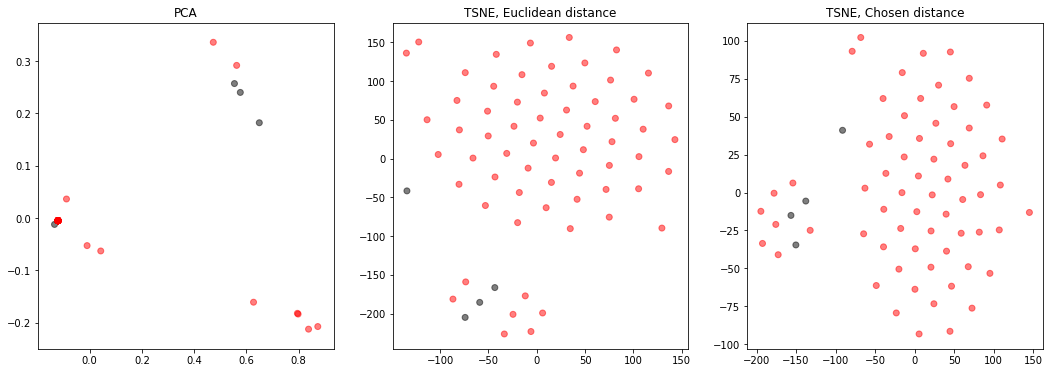

Clustering


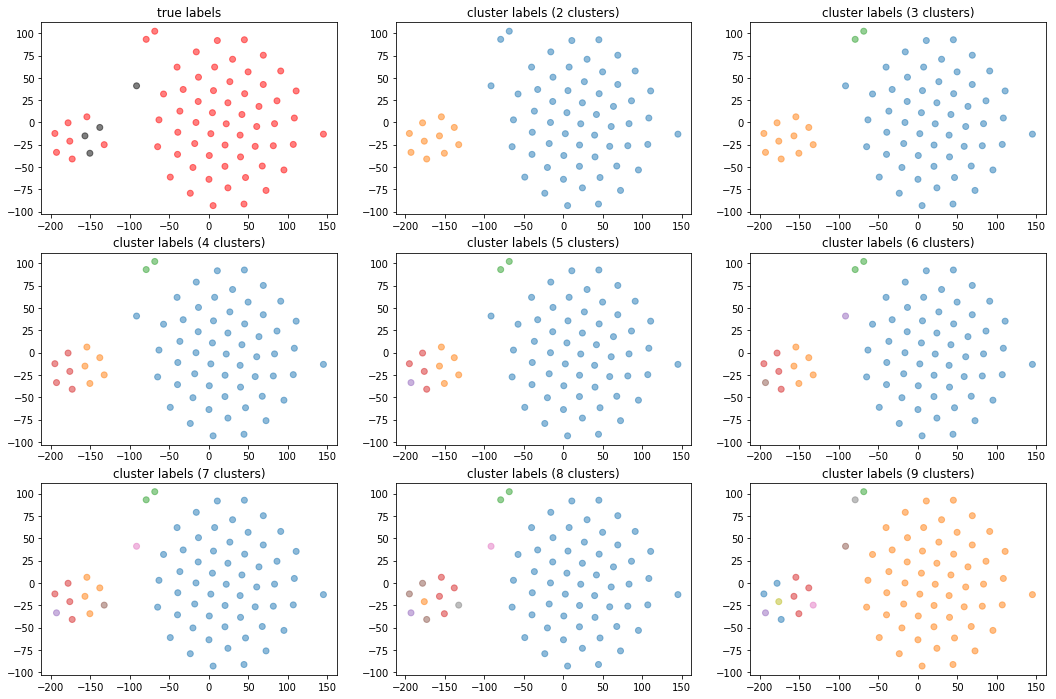

0 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
10,b'[CHP2004] J095549.8+693934',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
11,b'[MTK2001b] 8',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
12,b'[CHP2004] J095637.5+694137',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
13,b'CXOU J095601.7+694308',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
14,b'CXOU J095548.9+694010',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
15,b'CXOU J095527.1+693923',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
16,b'CXOU J095552.8+694020',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
17,b'CXOU J095552.4+694024',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
18,b'CXOU J095550.7+694039',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0
19,b'CXOU J095547.5+694120',B0Ve,b'1FGL J0956.5+6938 ',b'sbg ',"b'1FGL J0956.5+6938,2FGL J0955.9+6936,3FGL J09...",b'galaxy',0


1 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
1,b'LS IV -05 11',B,b' ',b'PWN ',b'',b'unid',0
7,b'[MT91] 213',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',1
8,b'Schulte 21',B0Ve,b'1FGL J2032.2+4127 ',b'PSR ',b'',b'unid',0
9,b'LS I +61 303',B0Ve,b'1FGL J0240.5+6113 ',b'HMB ',b'',b'bin',1
60,b'V* V479 Sct',B0Ve,b'1FGL J1826.2-1450 ',b'HMB ',b'',b'bin',1


2 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
0,b'SSTGC 519103',Be,b' ',b' ',b'',b'unid',0
4,b'GCIRS 8',O,b' ',b' ',b'',b'unid',0


3 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
2,b'GCIRS 1W',B,b' ',b' ',b'',b'unid',0
5,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
6,b'[MCD2010] 13',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0
56,b'[KRL2007b] 332',B0Ve,b' ',b'PWN ',b'',b'unid',0


4 cluster


,s_MAIN_ID,s_class,gev_1FGL_Name,gev_CLASS1,tev_fermi_names,tev_classes,marked
3,b'[MCD2010] 18',O,b'1FGL J1746.4-2849c',b'pwn ',b'',b'unid',0


centroids:


,gev_nuFnu10000_100000,gev_nuFnu1000_3000,gev_nuFnu100_300,gev_nuFnu3000_10000,gev_nuFnu300_1000,gev_nuFnu30_100,s_FLUX_U,s_FLUX_B,s_FLUX_V,s_FLUX_R,...,s_FLUX_u,s_FLUX_g,s_FLUX_r,s_FLUX_i,s_FLUX_z,tev_0.3TeV,tev_1TeV,tev_3TeV,tev_10TeV,tev_30TeV
0,0.114535,0.288122,0.243013,0.120108,0.232832,0.0,5.511877e-15,2.194320e-14,2.204547e-08,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.000059,0.000036,0.000028,0.000038,0.000076
1,0.003268,0.012250,0.007269,0.008862,0.009644,0.0,1.115758e-04,9.823123e-04,4.657124e-03,0.001378,...,0.0,0.000056,0.000412,0.001365,0.0,0.002559,0.003551,0.002316,0.001292,0.000657
2,0.013173,0.333859,0.020266,0.139161,0.321538,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.021575,0.017505,0.011808,0.004025,0.000396
3,0.006828,0.044097,0.001162,0.024807,0.030465,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.002988,0.004084,0.002664,0.001470,0.000885
4,0.011399,0.129145,0.001246,0.070802,0.082033,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.005744,0.000322,0.000969,0.000719,0.001111


In [19]:
metric_function = "correlation"
spectra_distances = pairwise_distances(spectra[spectrum_columns], metric=metric_function)
build_images()
print_clusters_structure(5)